In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet18_Weights

In [6]:
path='images/normal/Ex002000.T000.D000.P000.H000.LA.TIF'
image = cv2.imread(path)

x = np.array(image)
print("Image Shape:", x.shape)
print("Image Data Type:", x.dtype)
print("Min Pixel Value:", x.min())
print("Max Pixel Value:", x.max())

Image Shape: (2488, 3312, 3)
Image Data Type: uint8
Min Pixel Value: 0
Max Pixel Value: 9


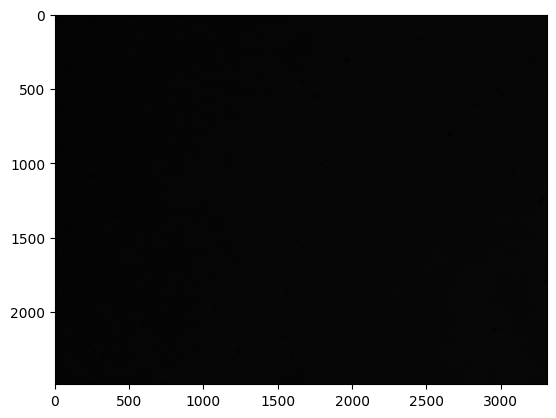

In [7]:
plt.imshow(image)

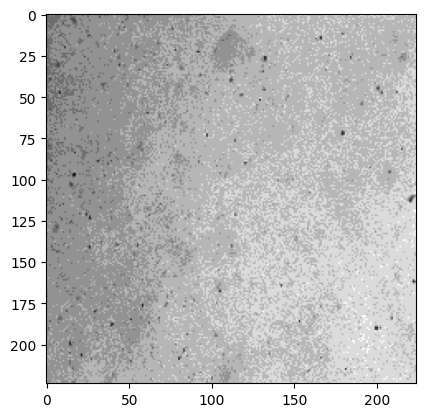

In [8]:
resized_image=cv2.resize(image, (224, 224))
x = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(x)

In [2]:
class Load_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.TIF'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [3]:
class Preprocess:
    def __call__(self, image):
        sample = np.array(image)
        sample = cv2.normalize(sample, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        processed_image = Image.fromarray(sample).convert('RGB')
        return processed_image

Epoch [1/100], Loss: 0.0323
Epoch [2/100], Loss: 0.0322
Epoch [3/100], Loss: 0.0321
Epoch [4/100], Loss: 0.0320
Epoch [5/100], Loss: 0.0317
Epoch [6/100], Loss: 0.0313
Epoch [7/100], Loss: 0.0303
Epoch [8/100], Loss: 0.0282
Epoch [9/100], Loss: 0.0241
Epoch [10/100], Loss: 0.0176
Epoch [11/100], Loss: 0.0144
Epoch [12/100], Loss: 0.0154
Epoch [13/100], Loss: 0.0107
Epoch [14/100], Loss: 0.0092
Epoch [15/100], Loss: 0.0094
Epoch [16/100], Loss: 0.0086
Epoch [17/100], Loss: 0.0075
Epoch [18/100], Loss: 0.0081
Epoch [19/100], Loss: 0.0077
Epoch [20/100], Loss: 0.0066
Epoch [21/100], Loss: 0.0069
Epoch [22/100], Loss: 0.0064
Epoch [23/100], Loss: 0.0054
Epoch [24/100], Loss: 0.0059
Epoch [25/100], Loss: 0.0045
Epoch [26/100], Loss: 0.0051
Epoch [27/100], Loss: 0.0040
Epoch [28/100], Loss: 0.0047
Epoch [29/100], Loss: 0.0035
Epoch [30/100], Loss: 0.0042
Epoch [31/100], Loss: 0.0034
Epoch [32/100], Loss: 0.0036
Epoch [33/100], Loss: 0.0031
Epoch [34/100], Loss: 0.0032
Epoch [35/100], Loss: 0

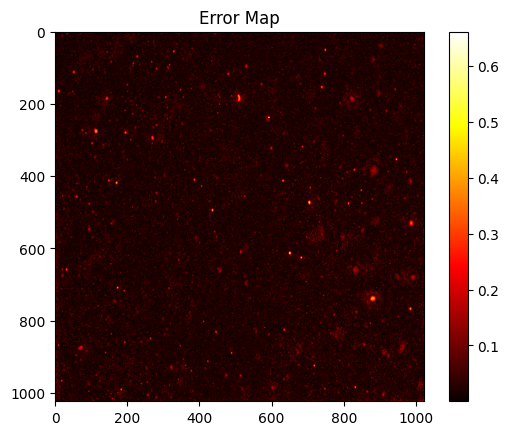

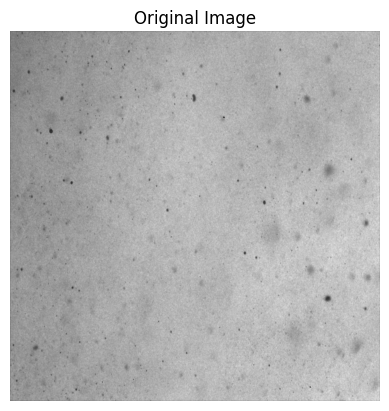

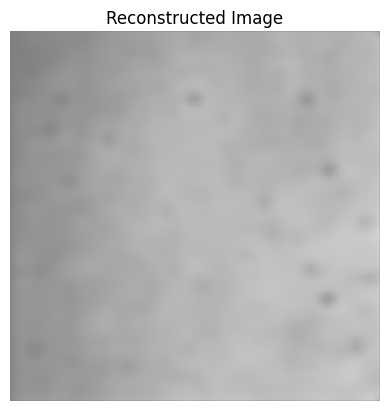

In [16]:
transform = transforms.Compose([
    Preprocess(),
    transforms.Resize((1024,1024)),
    transforms.ToTensor(),
])

dataset = Load_data(root_dir='images/normal', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

pretrained_encoder = models.vgg16(weights="IMAGENET1K_V1")
encoder = nn.Sequential(*list(pretrained_encoder.features.children())[:-1])

class Autoencoder(nn.Module):
    def __init__(self, encoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 28x28 -> 56x56
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 56x56 -> 112x112
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),    # 112x112 -> 224x224
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(encoder).to(device)
autoencoder = nn.DataParallel(autoencoder)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

num_epochs = 100
for epoch in range(num_epochs):
    for img in dataloader:
        img = img.to(device)
        
        # forward pass
        output = autoencoder(img)
        
        loss = criterion(output, img)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


sample_img = next(iter(dataloader))
sample_img = sample_img.to(device)

# forward pass sample_img through our trained model
with torch.no_grad():
    reconstructed_img = autoencoder(sample_img)

reconstructed_img = torch.clamp(reconstructed_img, 0, 1)

error_map = torch.abs(sample_img - reconstructed_img).mean(dim=1).cpu().numpy()
error_map_image = error_map[0] 
plt.imshow(error_map_image, cmap="hot")
plt.colorbar()
plt.title("Error Map")
plt.show()

def display_image(tensor, title="Image"):
    img = tensor.cpu().detach().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1] range
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

display_image(sample_img[0], title="Original Image")
display_image(reconstructed_img[0], title="Reconstructed Image")

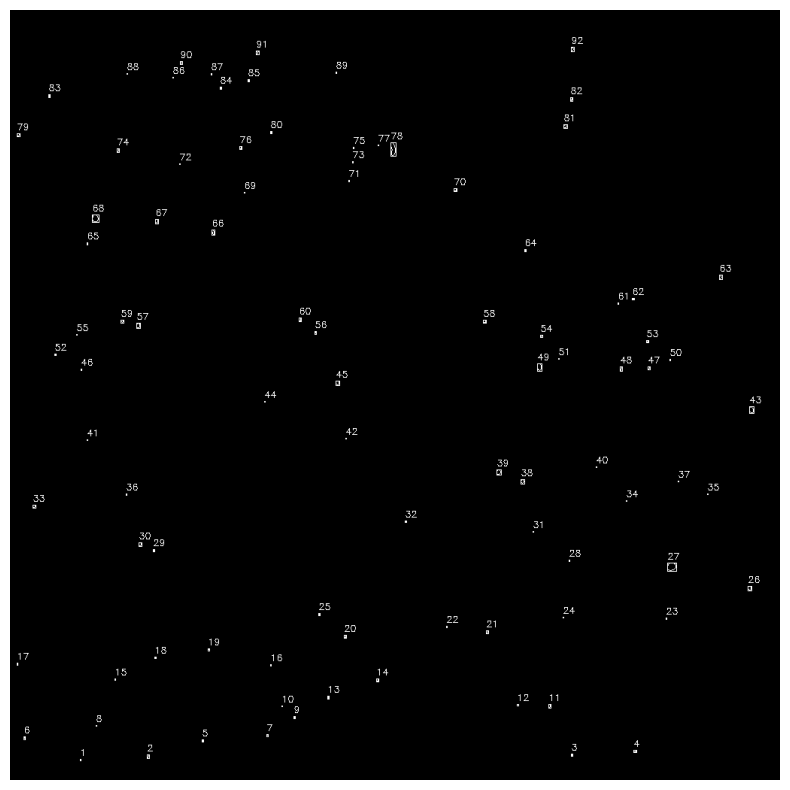

Sample_img
Number of particles: 92
Particle sizes: [0.0, 6.0, 1.5, 5.5, 1.5, 2.0, 1.5, 0.0, 1.5, 0.0, 7.0, 0.5, 2.0, 5.0, 0.0, 0.0, 0.0, 1.0, 1.0, 5.0, 4.5, 0.0, 0.0, 0.0, 1.0, 17.0, 87.5, 0.0, 1.0, 10.5, 0.0, 1.0, 7.5, 0.0, 0.0, 0.0, 0.0, 12.5, 24.5, 0.0, 0.0, 0.0, 31.0, 0.0, 16.5, 0.0, 4.0, 6.0, 37.0, 0.0, 0.0, 1.0, 3.0, 2.5, 0.0, 2.0, 19.5, 8.5, 5.5, 6.5, 0.0, 2.0, 9.0, 1.5, 0.0, 12.0, 11.5, 56.5, 0.0, 8.5, 0.0, 0.0, 0.0, 6.5, 0.0, 5.0, 0.0, 70.0, 8.0, 1.0, 10.0, 5.5, 2.5, 1.5, 1.5, 0.0, 0.0, 0.0, 0.0, 3.5, 6.5, 9.5]



In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

threshold = 0.275

binary_mask = (error_map_image > threshold).astype(np.uint8)

contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_image = np.zeros_like(error_map_image, dtype=np.uint8)

particle_count = 0
for i, contour in enumerate(contours):
    cv2.drawContours(contour_image, [contour], -1, (255), 1)  # Draw white contours

    # Optionally, draw bounding boxes
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contour_image, (x, y), (x + w, y + h), (255), 1)

    # Label each particle with a number
    cv2.putText(contour_image, f"{i + 1}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255), 1)

    particle_count += 1

# Plot the results
plt.figure(figsize=(10, 10))
plt.imshow(contour_image, cmap="gray")
plt.axis("off")
plt.show()

particle_sizes = []
for contour in contours:
    area = cv2.contourArea(contour)
    particle_sizes.append(area)

print(f"Sample_img")
print(f"Number of particles: {len(contours)}")
print(f"Particle sizes: {particle_sizes}\n")